In [1]:
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt
from scipy.io import loadmat
import utils as ut
import math
from scipy.optimize import curve_fit
from scipy.special import erf
from tqdm import trange

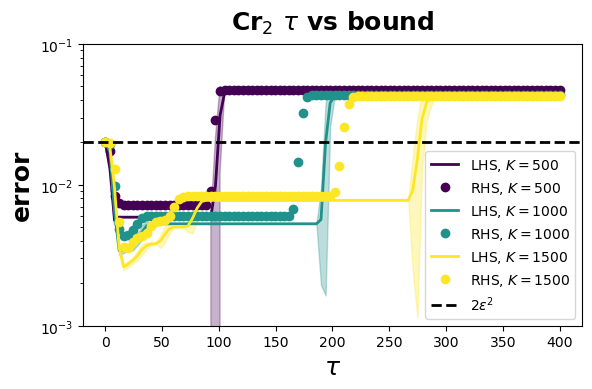

In [2]:
# --- Static parameters ---
overlap = 0.2
dt = 1.0
Tmax = 1500
noise = 0.1
eps = noise

# --- Load the data ---
#data = loadmat('./data/LiH_2989.mat')
data = loadmat('./data/Cr2_4000.mat')
E = data['E']
Et = ut.lam2lamt(E, E[0] - 0.2, E[-1] + 0.2)
phi = ut.generate_phi(overlap, len(Et))
dataS_full = ut.generate_samples_der(Et, phi, dt, Tmax, n=0)

# --- q function ---
def q(z):
    return np.exp(-z) * (1 + z)

# --- Combined bound function ---
def combined_bound_local(tau, x_hat, X_fft_shifted, x_true, eps, N):
    # Fourier amplitude of the true signal
    s_abs = np.abs(x_hat)
    s_real = np.real(x_hat)
    s_imag = np.imag(x_hat)
    
    # Indicator function: True if tau >= |s_hat|
    indicator = (tau >= s_abs)
    
    # Filter the noisy FFT: zero out entries below the threshold tau
    X_fft_filtered = X_fft_shifted * (np.abs(X_fft_shifted) > tau)
    x_denoised = scipy.fft.ifft(scipy.fft.ifftshift(X_fft_filtered))
    x_denoised[0] = 1.0  # ensure first element is fixed
    # Compute the L2 error (2-norm squared) with respect to the true signal
    LHS = np.linalg.norm(x_denoised - x_true, 2) ** 2
    
    # Term 1: using the q function
    q_argument = ((tau - s_abs)**2 * eps**(-2) * N**(-1) / 2)
    q_values = q(q_argument)
    term1_per_k = np.where(indicator, q_values, 1)
    term1 = 2 * N * eps**2 * (1/N) * np.sum(term1_per_k)
    
    # Term 2: using error functions
    factor = np.sqrt(2 * eps**2 * N)
    erf_term_real = erf((-s_real + tau) / factor) - erf((-s_real - tau) / factor)
    erf_term_imag = erf((-s_imag + tau) / factor) - erf((-s_imag - tau) / factor)
    term2_per_k = (s_abs**2 / (4*N)) * (erf_term_real * erf_term_imag)
    term2 = np.sum(term2_per_k)
    
    return term1 + term2, LHS

# --- Define different N values (truncations of the full signal) ---
N_list = [500, 1000, 1500]

# --- Define threshold factors ---
threshold_factors = np.linspace(0, 400, 100)

# Prepare a colormap so each N gets its own color
colors = plt.cm.viridis(np.linspace(0, 1, len(N_list)))

plt.figure(figsize=(6, 4))

# Loop over the different signal lengths
for idx, N in enumerate(N_list):
    # Truncate the full signal to length N
    dataS = dataS_full[:N]
    x_true = dataS.copy()
    
    # Compute the DFT of the noiseless signal
    x_hat = np.fft.fft(x_true)
    
    num_realizations = 100
    bound_all = np.zeros((num_realizations, len(threshold_factors)))
    lhs_all = np.zeros((num_realizations, len(threshold_factors)))
    tau_all = np.zeros((num_realizations, len(threshold_factors)))
    
    # Loop over noise realizations
    for r in trange(num_realizations, desc=f"N={N}", leave=False):
        # Generate a noisy realization (apply noise to both real and imaginary parts)
        ndataS = dataS + noise * np.random.randn(N) + 1j * noise * np.random.randn(N)
        clipped = np.clip(ndataS, -1, 1)
        clipped[0] = 1.0  
        x = clipped
        
        # FFT of the noisy signal
        X_fft = np.fft.fft(x)
        X_fft_shifted = np.fft.fftshift(X_fft)
        
        taus_local = threshold_factors
        tau_all[r, :] = taus_local
        
        for i, tau in enumerate(taus_local):
            bound_val, LHS_val = combined_bound_local(tau, x_hat, X_fft_shifted, x_true, eps, N)
            bound_all[r, i] = bound_val
            lhs_all[r, i] = LHS_val
            
    # Average and standard deviation over noise realizations
    mean_bound = np.mean(bound_all, axis=0)
    std_bound = np.std(bound_all, axis=0)
    mean_lhs = np.mean(lhs_all, axis=0)
    std_lhs = np.std(lhs_all, axis=0)
    mean_tau = np.mean(tau_all, axis=0)
    
    # Rescale by 1/N
    mean_bound_scaled = mean_bound / N
    mean_lhs_scaled = mean_lhs / N
    std_bound_scaled = std_bound / N
    std_lhs_scaled = std_lhs / N
    
    # Plot: LHS as a solid curve with uncertainty band
    plt.plot(mean_tau, mean_lhs_scaled, label=fr'LHS, $K={N}$', color=colors[idx], linewidth=2)
    plt.fill_between(mean_tau, mean_lhs_scaled - std_lhs_scaled, mean_lhs_scaled + std_lhs_scaled,
                     color=colors[idx], alpha=0.3)
    # Plot: RHS as markers only (no connecting line) using the same color
    plt.plot(mean_tau, mean_bound_scaled, marker='o', linestyle='None', label=fr'RHS, $K={N}$', color=colors[idx])

# Plot horizontal dashed line at eps^2 (note: after rescaling, this is independent of N)
plt.axhline(2 * eps**2, color='k', linestyle='--', linewidth=2, label=r'$2\epsilon^2$')
plt.xlabel(r'$\tau$', fontsize=18, fontweight='bold')
plt.ylabel('error', fontsize=18, fontweight='bold')
plt.title(r'Cr$_2$ $\tau$ vs bound', fontsize=18, fontweight='bold', pad=10)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()

# Set the y-axis to log scale
plt.yscale('log')
plt.ylim([1e-3, 1e-1])
plt.savefig('./figures/Cr2_bound_rescaled.pdf', bbox_inches='tight')
plt.show()

In [3]:
# --- Define different N values (truncations of the full signal) ---
N_list = list(range(100, 1500, 100))

# --- Define threshold factors ---
threshold_factors = np.linspace(0, 400, 100)

# Prepare a colormap so each N gets its own color
colors = plt.cm.viridis(np.linspace(0, 1, len(N_list)))
allmins = []
allmins_arg = []
plt.figure(figsize=(6, 4))

# Loop over the different signal lengths
for idx, N in enumerate(N_list):
    # Truncate the full signal to length N
    dataS = dataS_full[:N]
    x_true = dataS.copy()
    
    # Compute the DFT of the noiseless signal; using np.fft.fft for efficiency
    x_hat = np.fft.fft(x_true)
    
    num_realizations = 100
    bound_all = np.zeros((num_realizations, len(threshold_factors)))
    lhs_all = np.zeros((num_realizations, len(threshold_factors)))
    tau_all = np.zeros((num_realizations, len(threshold_factors)))
    
    # Loop over noise realizations
    for r in trange(num_realizations, desc=f"N={N}", leave=False):
        # Generate a noisy realization (apply noise to both real and imaginary parts)
        ndataS = dataS + noise * np.random.randn(N) + 1j * noise * np.random.randn(N)
        clipped = np.clip(ndataS, -1, 1)
        clipped[0] = 1.0  
        x = clipped
        
        # FFT of the noisy signal
        X_fft = np.fft.fft(x)
        X_fft_shifted = np.fft.fftshift(X_fft)
        
        taus_local = threshold_factors
        tau_all[r, :] = taus_local
        
        for i, tau in enumerate(taus_local):
            bound_val, LHS_val = combined_bound_local(tau, x_hat, X_fft_shifted, x_true, eps, N)
            bound_all[r, i] = bound_val
            lhs_all[r, i] = LHS_val
            
    # Average and standard deviation over noise realizations
    mean_bound = np.mean(bound_all, axis=0)
    std_bound = np.std(bound_all, axis=0)
    mean_lhs = np.mean(lhs_all, axis=0)
    std_lhs = np.std(lhs_all, axis=0)
    mean_tau = np.mean(tau_all, axis=0)
    
    # Rescale by 1/N
    mean_bound_scaled = mean_bound / N
    mean_lhs_scaled = mean_lhs / N
    std_bound_scaled = std_bound / N
    std_lhs_scaled = std_lhs / N
    
    min_rhs = np.min(mean_bound_scaled)
    allmins_arg.append(np.argmin(mean_bound_scaled))
    allmins.append(min_rhs)

<Figure size 600x400 with 0 Axes>

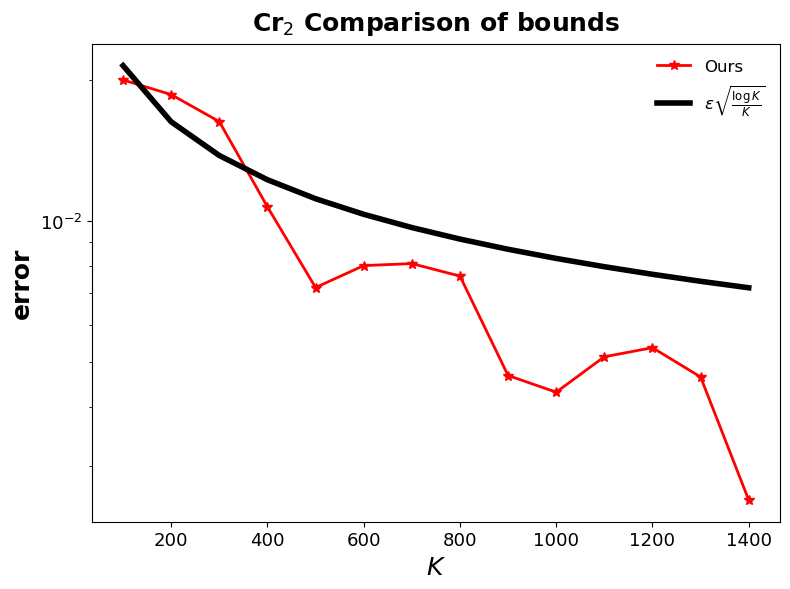

In [4]:
N_list_arr = np.array(N_list)

fig, ax = plt.subplots(figsize=(8, 6))
ax.semilogy(N_list_arr, allmins, marker='*', linestyle='-', lw=2, markersize=7, color='red', label='Ours')

# Plot the theoretical bound
ax.plot(N_list_arr, eps * np.sqrt(np.log(N_list_arr) / N_list_arr),
        color='black', linestyle='-', linewidth=4,
        label=r'$\varepsilon \sqrt{\frac{\log K}{K}}$')


ax.set_xlabel(r'$K$', fontsize=18, fontweight='bold')
ax.set_ylabel('error', fontsize=18, fontweight='bold')
ax.set_title('Cr$_2$ Comparison of bounds', fontsize=18, fontweight='bold', pad=10)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='upper right', frameon=False, fontsize=12)

plt.tight_layout()
#plt.savefig('./figures/cr2_bound_comparison.pdf')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


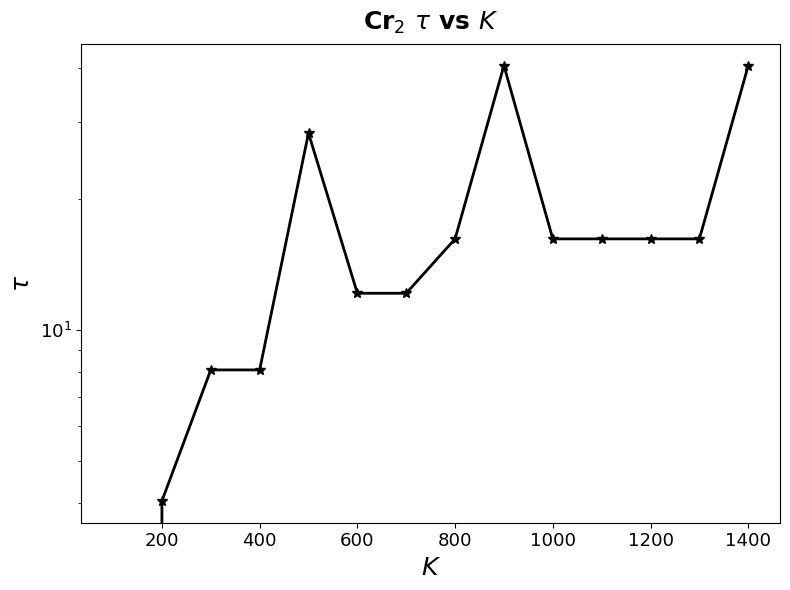

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data points with markers on a semilog-y scale
ax.semilogy(N_list_arr, threshold_factors[allmins_arg], marker='*', linestyle='-', lw=2, markersize=7, color='black')

ax.set_xlabel(r'$K$', fontsize=18, fontweight='bold')
ax.set_ylabel(r'$\tau$', fontsize=18, fontweight='bold')
ax.set_title(r'Cr$_2$ $\tau$ vs $K$', fontsize=18, fontweight='bold', pad=10)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='upper right', frameon=False, fontsize=12)

plt.tight_layout()
#plt.savefig('./figures/cr2_tr_vs_k.pdf')
plt.show()